## Demand Estimation Exercise

In this assignment, you will learn how to simulate market data and estimate simple random coefficient demand models. The assignment should serve as an introduction to the structural estimation in heterogenous product demand models.

Let's first define the model.


In [1]:
import simulate
import numpy as np 
import pandas as pd 
from sklearn import linear_model
import matplotlib.pyplot as plt
import pyblp


The first step is to initialize the model class

To do this you need to import the "simulation" module that was especially constructed for this course. Make sure the assignment notebook and the simulate are in the same folder if you have not prespecified a different path for the module.  (FIND A WAY FOR THE STUDENTS TO NOT RUN IT LOCAL, BUT ON THE GIT SERVER SUCH THAT THEY DO NOT NEED TO HAVE ANYTHING INSTALLED)

In [2]:
n_firms = 10
n_const = 10000
n_caract = 4
T = 100


market = simulate.Market_Data(n_firms, n_const, n_caract, T)
print(market)

Market with 10 firms and 10000 consumers over 100 time periods. 
 Firms sell differentiated product which have 4 product characteristics


This market is characterized by the following parameters that are unknown to the econometrician:

$\alpha_{\mu} =  0.5$
$\alpha_{\sigma} =  0.05$
These two parameters can be used for the lognormal distribution to find: -1.65 mean of the lognormal with standard deviation




$\beta_{\mu} =  [[1.47435481], [1.41511067] , [1.0707528 ], [2.39841642]]$ 



$\beta_{\sigma} = [[0.02938696], [0.02612406],  [0.00292152],  [0.01330291]]  $



In [3]:
print(market.beta_0)
print(market.beta_sd)
print(market.alpha_0)
print(market.alpha_0_sd)

[[2.43371435]
 [1.36983501]
 [2.20479267]
 [0.30766116]]
[[0.]
 [0.]
 [0.]
 [0.]]
-1.650783460888857
0.006821238081735126


In [4]:
df = market.generate_simulated_data()
print(df)

     market_ids  firm_ids        shares    prices      cost        xi  \
0             1         1  3.427316e-01  4.905888  3.262528 -0.042173   
1             1         2  4.645947e-01  4.561659  3.331514 -0.135383   
2             1         3  1.577988e-01  5.601977  3.358621  0.027024   
3             1         4  6.696938e-03  4.626180  3.311746 -0.032851   
4             1         5  3.783808e-04  6.069318  3.352858  0.219944   
..          ...       ...           ...       ...       ...       ...   
995         100         6  9.709297e-06  4.182855  3.295705 -0.192426   
996         100         7  7.142837e-05  6.290395  3.364446  0.177320   
997         100         8  2.763170e-10  6.224980  3.351038  0.253008   
998         100         9  1.349109e-04  7.530053  3.327199  0.394304   
999         100        10  7.136150e-01  3.515811  3.364513 -0.438902   

        char1     char2     char3     char4  
0    4.084113  3.486695  5.444982  4.720201  
1    5.950637  4.411340  3.1000

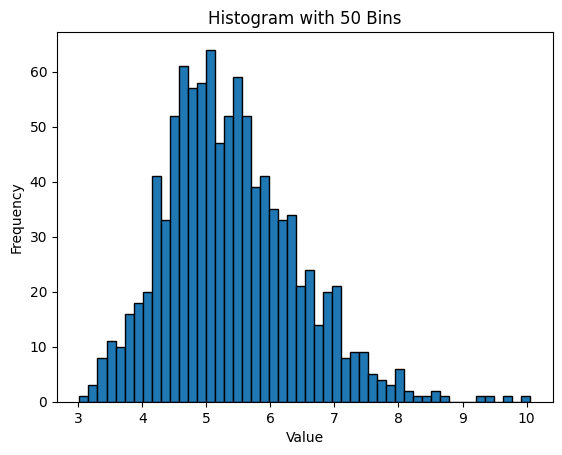

In [5]:
# try the standard probit model for finding the coefficients 
# Generate some random data for the histogram


# Create a histogram with 10 bins
plt.hist(market.prices, bins=50, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with 50 Bins')

# Display the plot
plt.show()

Trying to estimate with the logit function: 
 
y = ln(s_0) - ln(s_n)


In [6]:
reshape = np.reshape(market.market_shares, (T, n_firms))
sum_market_shares = np.sum(reshape, axis=1)
repeated_sum_shares = np.reshape(np.repeat(sum_market_shares, n_firms), (n_firms*T, 1))
y  = np.log(market.market_shares) - np.log(repeated_sum_shares)
print(y)
    

[[ -1.07080765]
 [ -0.76658986]
 [ -1.84643428]
 [ -5.00610483]
 [ -7.87960942]
 [-10.4364369 ]
 [ -8.66356269]
 [-18.18559718]
 [ -6.34071578]
 [ -3.65604884]
 [ -1.95406049]
 [ -1.18578386]
 [ -4.49315045]
 [ -4.85709328]
 [ -6.16477923]
 [-16.64454586]
 [ -5.56477824]
 [-19.66184891]
 [ -3.75605901]
 [ -0.68412976]
 [ -3.41631262]
 [ -1.31660305]
 [ -1.47351593]
 [ -4.86999722]
 [ -8.805575  ]
 [-10.48297219]
 [ -8.12838361]
 [-18.93578663]
 [ -3.42188837]
 [ -0.84581627]
 [ -2.2736121 ]
 [ -1.79172807]
 [ -2.31350233]
 [ -6.1190876 ]
 [ -5.0944231 ]
 [-13.2057424 ]
 [ -7.32603123]
 [-21.31338227]
 [ -5.00949607]
 [ -0.48481905]
 [ -2.66460873]
 [ -1.08822804]
 [ -0.54192313]
 [ -8.93299564]
 [ -8.71912386]
 [-11.0384451 ]
 [ -6.78595085]
 [-21.66542243]
 [ -6.22257373]
 [ -4.76688161]
 [ -1.92179837]
 [ -2.36249543]
 [ -0.8523641 ]
 [ -9.00034448]
 [ -8.15571029]
 [-10.3716083 ]
 [ -6.36296208]
 [-21.77141381]
 [ -3.19882958]
 [ -1.23756432]
 [ -1.97944341]
 [ -0.5951187 ]
 [ -3.93

In [7]:
x = df[['prices','char1', 'char2', 'char3', 'char4']]
y = y
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# This already looks very good! Even without making in the IV 

Intercept: 
 [-23.38457418]
Coefficients: 
 [[-1.31698289  2.44010242  1.36937421  2.20713399  0.30937712]]


In [8]:

print(market.beta_0)
print(market.beta_sd)
print(market.alpha_0)
print(market.alpha_0_sd)


[[2.43371435]
 [1.36983501]
 [2.20479267]
 [0.30766116]]
[[0.]
 [0.]
 [0.]
 [0.]]
-1.650783460888857
0.006821238081735126


Estimation with the PyBLP package (without supply side problem)


In [9]:
X1_formulation = pyblp.Formulation('0 + prices + char1 + char2 + char3 + char4')
X2_formulation = pyblp.Formulation('0 + prices')
product_formulations = (X1_formulation, X2_formulation)
product_formulations

(prices + char1 + char2 + char3 + char4, prices)

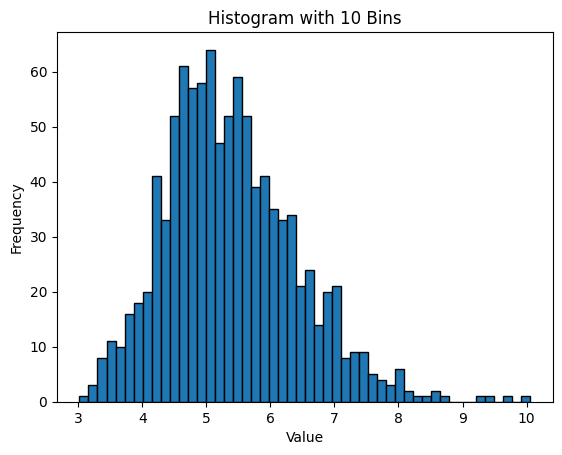

In [10]:
# Create a histogram with 10 bins
plt.hist(market.prices, bins=50, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with 10 Bins')

# Display the plot
plt.show()

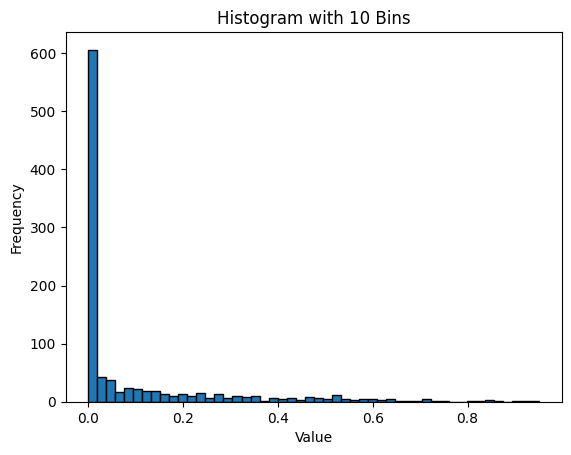

In [11]:
# Create a histogram with 10 bins
plt.hist(market.market_shares, bins=50, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with 10 Bins')

# Display the plot
plt.show()

In [12]:
mc_integration = pyblp.Integration('monte_carlo', size=50, specification_options={'seed': 0})
mc_integration

Configured to construct nodes and weights with Monte Carlo simulation with options {seed: 0}.

In [13]:
mc_problem = pyblp.Problem(product_formulations, df, integration=mc_integration)


Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T    N     F    I     K1    K2    MD 
---  ----  ---  ----  ----  ----  ----
100  1000  10   5000   5     1     4  

Formulations:
       Column Indices:           0       1      2      3      4  
-----------------------------  ------  -----  -----  -----  -----
 X1: Linear Characteristics    prices  char1  char2  char3  char4
X2: Nonlinear Characteristics  prices                            


/Users/api970/Library/Python/3.9/lib/python/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)


In [14]:
bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-4})


In [15]:
# results1 = mc_problem.solve(sigma=np.ones((1, 1)), optimization=bfgs)



Estimation including costs (with the cost structure of the firm and pricing)


In [16]:
# product_data = df
# # Setting up the formulations
# product_formulations = (pyblp.Formulation('0 + prices + char1 + char2 + char3 + char4'), pyblp.Formulation('0 + prices'),pyblp.Formulation('cost'))

# mc_integration = pyblp.Integration('monte_carlo', size=100, specification_options={'seed': 0})
# problem = pyblp.Problem(product_formulations, product_data, integration=mc_integration)
# bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-6})
# estimation = problem.solve(sigma=(np.ones((1, 1))/2),beta=[1., 1., 1., 1., 1.], optimization=bfgs)

## Final Results from all the techniques used

1. Simple logit model 
2. PyBLP RC with all elements as RC but no IV estimates 
3. PyBLP also with supply side moments 
